#### Convolutional Neural net -     
#### contains data preprocess, model fit, image prediction, model residuals

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Dense,Conv2D, Dropout, Activation, MaxPooling2D, Flatten
import time

#### Preprocess

In [2]:
# preprocess: data import, shuffle, axes switch. detailed in notebk 'rgb_data_load_mod.ipynb'.

b = np.load('/Users/anirudhputrevu/Downloads/depth_training_data.npz')
data_rgb = b['rgb_images']                # RGB DATA 
data_depth = b['depth_maps']              # DEPTH DATA 
data_rgb = data_rgb/255
data_depth = data_depth - data_depth.min()
# switch axes for plotting
data_rgb = data_rgb.transpose(0,2,3,1)
data_depth = data_depth.transpose(0,2,3,1)
# shuffle images
random.seed(400)
random.shuffle(data_depth)     # inplace method
random.seed(400)
random.shuffle(data_rgb)

# change to 32 bit floats
data_rgb = data_rgb.astype(np.float32)       # size(type) modification for nn 
data_depth = data_depth.astype(np.float32)

# Flatten output dense image
Y = data_depth.reshape(3500,np.prod(data_depth.shape[1:]))

x_train, x_test, y_train, y_test = train_test_split(data_rgb, Y, test_size= 0.20, random_state = 80)

# splitting actual color image w/ same random state for plotting with depth & predicted depth image
rgb_train, rgb_test = train_test_split(data_rgb, test_size= 0.20, random_state = 80)

data_rgb.shape, data_depth.shape

((3500, 96, 96, 3), (3500, 96, 96, 1))

#### Model fit  - conv, pooling, dense layers applied to input rgb image
#### validating on test data 

In [3]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(9216, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0     

2022-01-05 19:15:41.344744: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
%%time
m = model.fit(x_train,y_train,validation_split=0.2, epochs=50,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=5,
                    restore_best_weights=True )])                    

Epoch 1/50
70/70 [==============================] - 42s 591ms/step - loss: 0.2567 - val_loss: 0.0789
Epoch 2/50
70/70 [==============================] - 41s 590ms/step - loss: 0.0413 - val_loss: 0.0174
Epoch 3/50
70/70 [==============================] - 41s 590ms/step - loss: 0.0158 - val_loss: 0.0150
Epoch 4/50
70/70 [==============================] - 41s 592ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 5/50
70/70 [==============================] - 41s 589ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 6/50
70/70 [==============================] - 41s 592ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 7/50
70/70 [==============================] - 41s 590ms/step - loss: 0.0133 - val_loss: 0.0121
Epoch 8/50
70/70 [==============================] - 43s 608ms/step - loss: 0.0125 - val_loss: 0.0130
Epoch 9/50
70/70 [==============================] - 42s 598ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 10/50
70/70 [==============================] - 41s 584ms/step - loss: 0.0114 - val_lo

In [5]:
print("shape before fully connected layer",x.shape)
print("final output shape",outputs.shape)

shape before fully connected layer (None, 64)
final output shape (None, 9216)


#### changing conv. output filters and 1 more dense layer. 

In [6]:
# predict on test data model s with 1 dense layer
predicted_depth = model.predict(x_test)
predicted_depth.shape

(700, 9216)

In [7]:
print(f" MSE: {mean_squared_error(y_test, predicted_depth) :3.5}")
print(f" Test R^2 Score: {r2_score(y_test, predicted_depth) :3.5}")

 MSE: 0.0061782
 Test R^2 Score: 0.74711


#### plotting predictions

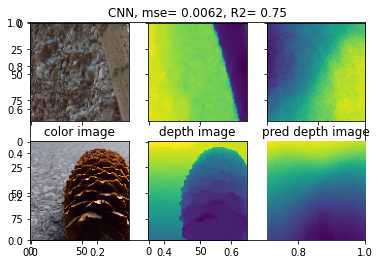

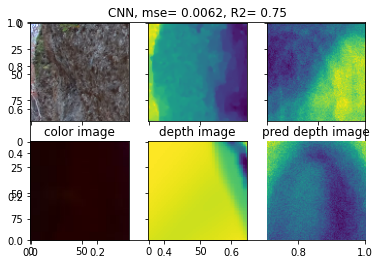

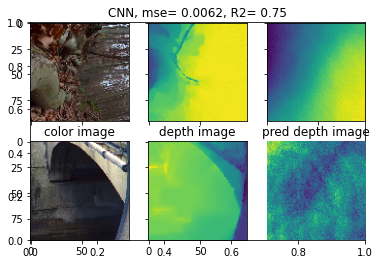

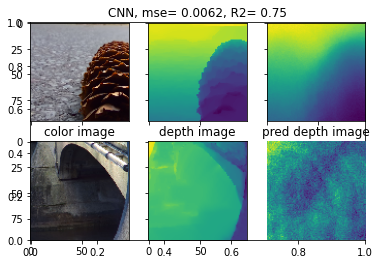

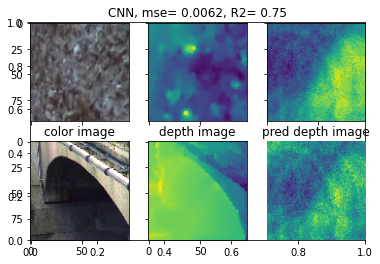

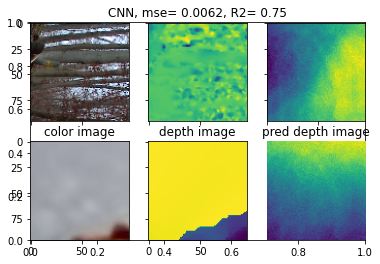

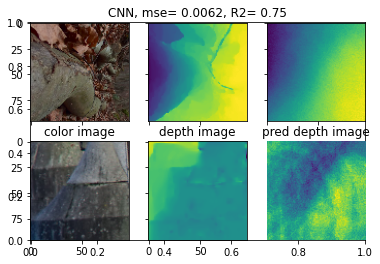

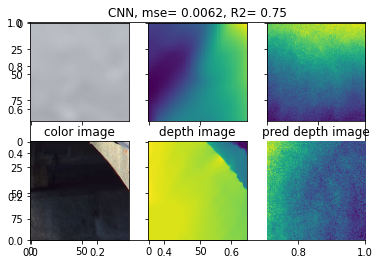

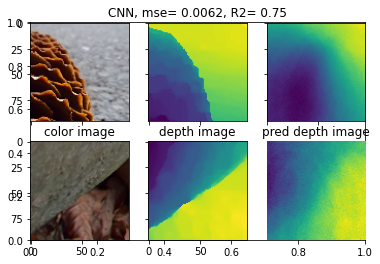

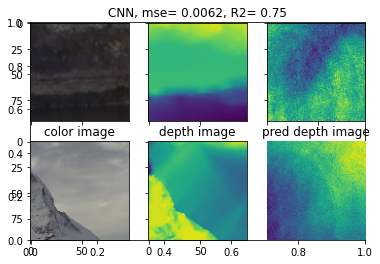

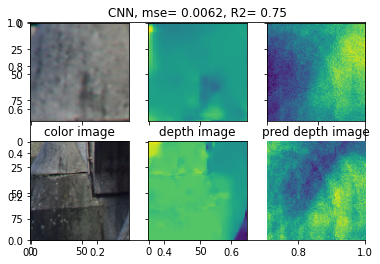

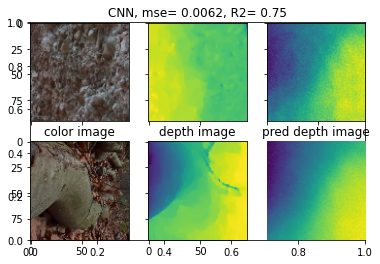

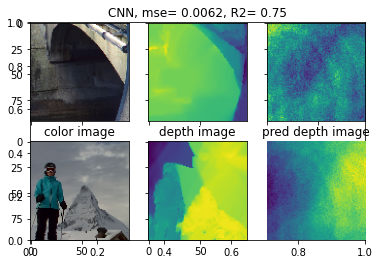

In [8]:
c = [43,56,68,89,1,19,145,630,520,469,600,200,245]
for i in c:
    mse = mean_squared_error(y_test, predicted_depth)
    r2 = r2_score(y_test, predicted_depth)
    f = plt.figure()
    plt.title(f"CNN, mse= {mse :3.2}, R2= {r2 :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[i])
    axarr[0,1].imshow(y_test[i].reshape(96,96,1))
    axarr[0,2].imshow(predicted_depth[i].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[i+1])
    axarr[1,1].imshow(y_test[i+1].reshape(96,96,1))
    axarr[1,2].imshow(predicted_depth[i+1].reshape(96,96,1))
    axarr[1,0].set_title('color image')
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('pred depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### adding another dense layer to the fully connected network.

In [9]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(9216, activation='linear')(x)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model1.compile(optimizer='adam',loss='mse')

model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0   

In [10]:
print("shape before fully connected layer",x.shape)
print("final output shape",outputs.shape)

shape before fully connected layer (None, 1024)
final output shape (None, 9216)


In [11]:
%%time
m1 = model1.fit(x_train,y_train,validation_split=0.2, epochs=50,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=5,
                    restore_best_weights=True )])         

Epoch 1/50
70/70 [==============================] - 57s 798ms/step - loss: 0.1642 - val_loss: 0.0227
Epoch 2/50
70/70 [==============================] - 55s 793ms/step - loss: 0.0173 - val_loss: 0.0151
Epoch 3/50
70/70 [==============================] - 55s 791ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 4/50
70/70 [==============================] - 55s 789ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 5/50
70/70 [==============================] - 56s 800ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 6/50
70/70 [==============================] - 55s 783ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 7/50
70/70 [==============================] - 56s 797ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 8/50
70/70 [==============================] - 56s 796ms/step - loss: 0.0116 - val_loss: 0.0094
Epoch 9/50
70/70 [==============================] - 55s 785ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 10/50
70/70 [==============================] - 55s 785ms/step - loss: 0.0123 - val_lo

In [12]:
# predict on test data model s with 1 dense layer
pred_depth = model1.predict(x_test)
pred_depth.shape

(700, 9216)

In [13]:
print(f" MSE: {mean_squared_error(y_test, pred_depth) :3.5}")
print(f" Test R^2 Score: {r2_score(y_test, pred_depth) :3.5}")

 MSE: 0.0034943
 Test R^2 Score: 0.8564


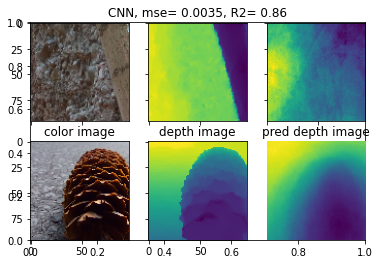

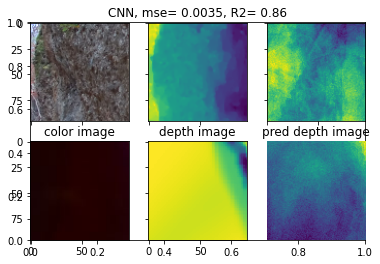

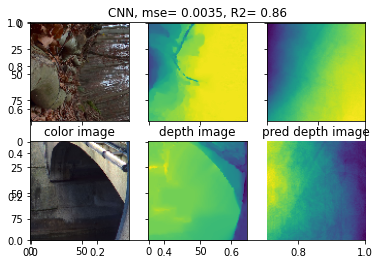

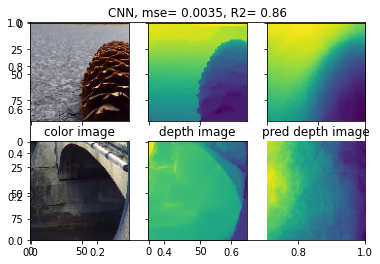

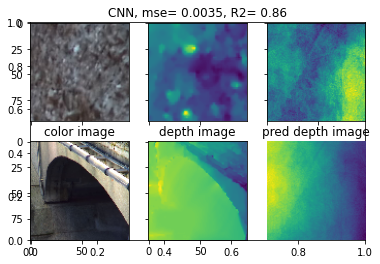

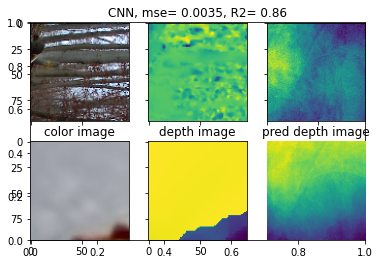

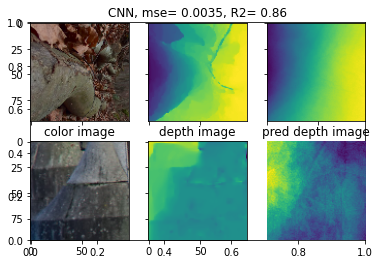

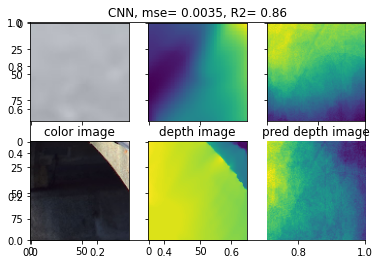

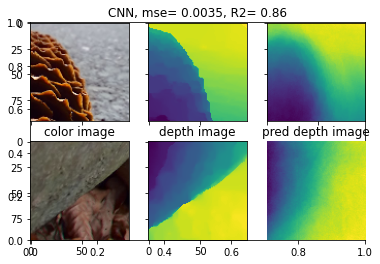

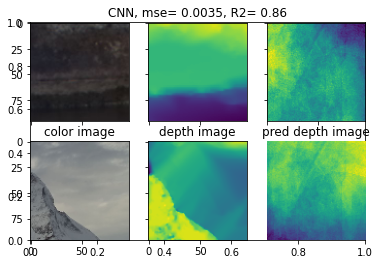

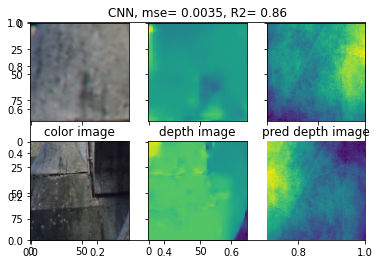

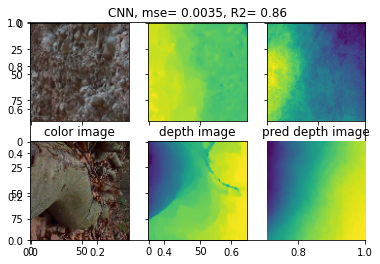

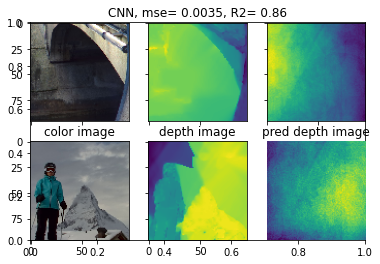

In [14]:
c = [43,56,68,89,1,19,145,630,520,469,600,200,245]
for i in c:
    mse = mean_squared_error(y_test, pred_depth)
    r2 = r2_score(y_test, pred_depth)
    f = plt.figure()
    plt.title(f"CNN, mse= {mse :3.2}, R2= {r2 :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[i])
    axarr[0,1].imshow(y_test[i].reshape(96,96,1))
    axarr[0,2].imshow(pred_depth[i].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[i+1])
    axarr[1,1].imshow(y_test[i+1].reshape(96,96,1))
    axarr[1,2].imshow(pred_depth[i+1].reshape(96,96,1))
    axarr[1,0].set_title('color image')
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('pred depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### adding another conv layer of 128 filters, same kernel/filter window

In [15]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(9216, activation='linear')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2.compile(optimizer='adam',loss='mse')

model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        7379

In [16]:
print("shape before fully connected layer",x.shape)
print("final output shape",outputs.shape)

shape before fully connected layer (None, 1024)
final output shape (None, 9216)


In [17]:
%%time
m2 = model2.fit(x_train,y_train,validation_split=0.2, epochs=50,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=5,
                    restore_best_weights=True )])   

Epoch 1/50
70/70 [==============================] - 63s 894ms/step - loss: 0.1767 - val_loss: 0.0363
Epoch 2/50
70/70 [==============================] - 62s 880ms/step - loss: 0.0198 - val_loss: 0.0167
Epoch 3/50
70/70 [==============================] - 62s 879ms/step - loss: 0.0143 - val_loss: 0.0133
Epoch 4/50
70/70 [==============================] - 61s 879ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 5/50
70/70 [==============================] - 61s 872ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 6/50
70/70 [==============================] - 62s 881ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 7/50
70/70 [==============================] - 61s 873ms/step - loss: 0.0111 - val_loss: 0.0094
Epoch 8/50
70/70 [==============================] - 62s 881ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 9/50
70/70 [==============================] - 61s 879ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 10/50
70/70 [==============================] - 61s 876ms/step - loss: 0.0097 - val_lo

In [18]:
# predict on test data model s with 1 dense layer
predi_depth = model2.predict(x_test)
predi_depth.shape

(700, 9216)

In [19]:
print(f" MSE: {mean_squared_error(y_test, predi_depth) :3.5}")
print(f" Test R^2 Score: {r2_score(y_test, predi_depth) :3.5}")

 MSE: 0.0043485
 Test R^2 Score: 0.82093


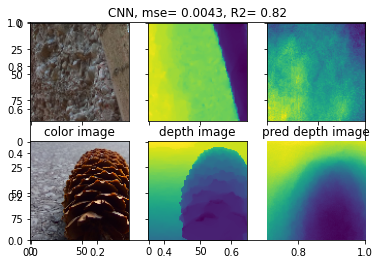

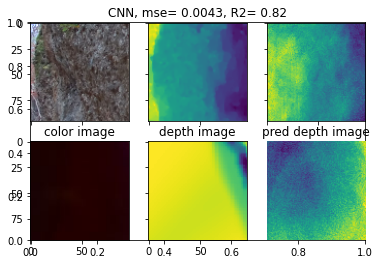

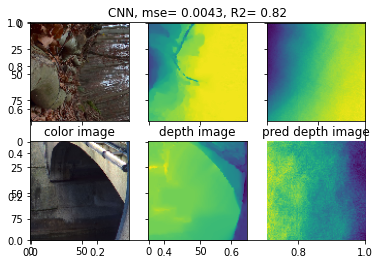

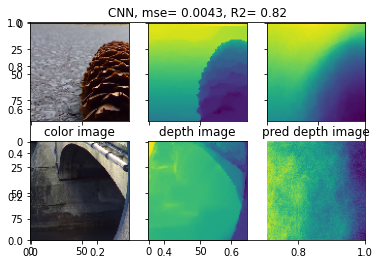

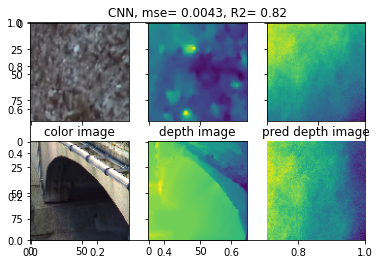

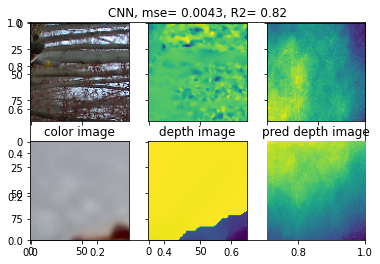

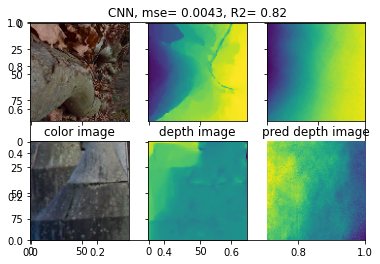

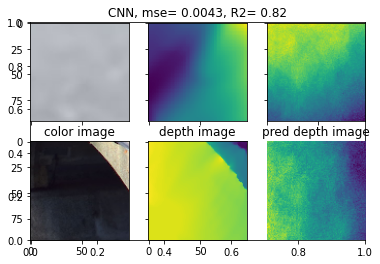

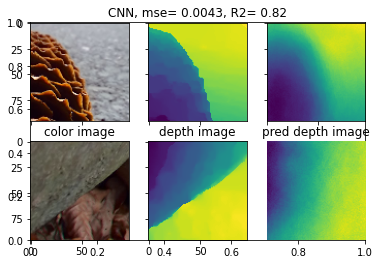

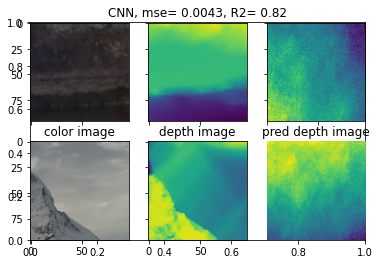

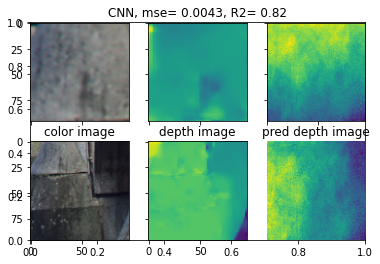

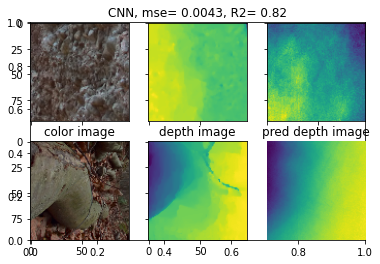

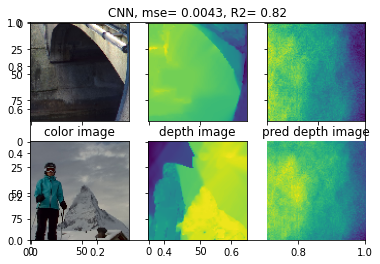

In [21]:
c = [43,56,68,89,1,19,145,630,520,469,600,200,245]
for i in c:
    mse = mean_squared_error(y_test, predi_depth)
    r2 = r2_score(y_test, predi_depth)
    f = plt.figure()
    plt.title(f"CNN, mse= {mse :3.2}, R2= {r2 :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(rgb_test[i])
    axarr[0,1].imshow(y_test[i].reshape(96,96,1))
    axarr[0,2].imshow(predi_depth[i].reshape(96,96,1))
    axarr[1,0].imshow(rgb_test[i+1])
    axarr[1,1].imshow(y_test[i+1].reshape(96,96,1))
    axarr[1,2].imshow(predi_depth[i+1].reshape(96,96,1))
    axarr[1,0].set_title('color image')
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('pred depth image')
    for ax in axarr.flat:
        ax.label_outer()

## We see model2 w/ 3 conv layers & 3 dense layers 
## has best mse of 0.0035 

In [22]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        7379

#### Residuals 

In [24]:
res = pred_depth - y_test
res.shape

(700, 9216)


 Residuals summary 
 count    9216.000000
mean       -0.055165
std         0.008828
min        -0.081956
25%        -0.061582
50%        -0.056865
75%        -0.049381
max        -0.030931
dtype: float64


Text(0, 0.5, 'predicted depth')

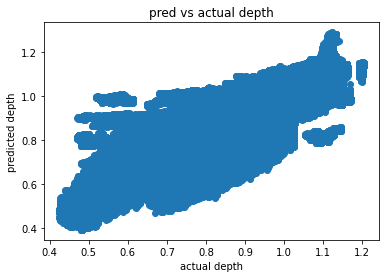

In [25]:
# plot res vs coefs 
res = pd.Series(res[1])

print("\n Residuals summary \n",res.describe())

fig = plt.figure()
plt.scatter(y_test, pred_depth)
plt.title("pred vs actual depth")
plt.xlabel("actual depth")
plt.ylabel("predicted depth")